In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import modelofuncoes as mf

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

importing Jupyter notebook from modelofuncoes.ipynb


### Curva ROC

In [2]:
def exibirCurvaROC(modeloClassificador, x_test, y_test):
    y_preds = modeloClassificador.predict_proba(x_test)

    # take the second column because the classifier outputs scores for the 0 class as well
    preds = y_preds[:,1]

    # fpr (false-positive-rate) e tpr (true-positive-rate)
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    auc_score = metrics.auc(fpr, tpr)

    # Construindo o Gráfico
    plt.clf()
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
    plt.plot([0,1],[0,1],'r--')

    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.legend(loc='lower right')
    plt.show()

### Avaliando o Smote

In [3]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

def aplicarSmote(base, alvo):

    X_smt = base.drop(alvo, axis = 1)
    y_smt = base[alvo]
    
    # Contar o número de ocorrências
    # np.bincount(y_smt)
    
    # Carregar o Smote
    smt = SMOTE()
    
    # Aplicar o Smote
    X_smt, y_smt = smt.fit_resample(X_smt, y_smt)
    
    # Contar o número de ocorrências
    # np.bincount(y_smt)
    
    # Convertendo em DF
    smoteBase = pd.DataFrame(X_smt)
    smoteBase[alvo] = y_smt
    
    return smoteBase

In [4]:
# Padrão - (Modelo OC)
hiperparametrosGB = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, 
                           random_state=1859, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


# Smote 60/40 (Modelo IC)
# hiperparametrosGB = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
#                            learning_rate=0.05, loss='deviance', max_depth=6,
#                            max_features='sqrt', max_leaf_nodes=None,
#                            min_impurity_decrease=0.1, min_impurity_split=None,
#                            min_samples_leaf=5, min_samples_split=4,
#                            min_weight_fraction_leaf=0.0, n_estimators=280,
#                            n_iter_no_change=None, presort='deprecated',
#                            random_state=4156, subsample=0.75, tol=0.0001,
#                            validation_fraction=0.1, verbose=0,
#                            warm_start=False)

## Desempenho dos Modelos Escolhidos
---------

### Definindo as bases de dados

In [5]:
# Modelo OC (7030 e Smote 7030)
# url = 'PreProcessamento/balanceadas/OC/ba-oc-7030-sp.xlsx'
url = 'PreProcessamento/balanceadas/Smote/sm-oc-6040-sp.xlsx'

# Modelo IC (Smote 6040)
#url = 'PreProcessamento/balanceadas/Smote/sm-ic-6040-sp.xlsx'
# url = 'PreProcessamento/balanceadas/IC/ba-ic-6040-sp.xlsx'

alvo = 'evolucaoCaso'
baseFinal = pd.read_excel(url)

In [6]:
print(baseFinal.shape)
print(baseFinal[alvo].value_counts())

(4292, 38)
0    2146
1    2146
Name: evolucaoCaso, dtype: int64


### Reduzindo os Atributos

In [7]:
# (Modelo OC)
atributosSelecionados = ['faixaetaria', 'dispneia', 'qntVacinas', 'coriza', 'dorDeGarganta', 
                       'dorDeCabeca', 'obesidade', 'diabetes', 'faixaDiasSintomas', 'evolucaoCaso']

# (Modelo IC)
# atributosSelecionados = ['faixaetaria', 'dorDeCabeca', 'dorDeGarganta', 'renal', 'dispneia', 'diabetes',  
#                        'tosse', 'qntVacinas', 'faixaDiasSintomas', 'coriza', 'febre', 'evolucaoCaso']

In [8]:
baseFinalReduzida = baseFinal.loc[:, atributosSelecionados]

In [9]:
#baseFinalReduzida['evolucaoCaso'] = baseFinalReduzida['evolucaoCaso'].map({0:2, 1:1})
baseFinalReduzida['evolucaoCaso'].value_counts()

0    2146
1    2146
Name: evolucaoCaso, dtype: int64

In [10]:
baseFinalReduzida.shape

(4292, 10)

### Carregando o Modelo Escolhido

In [11]:
x_train, x_test, y_train, y_test = train_test_split(baseFinalReduzida.drop(alvo,axis=1),
                                                    baseFinalReduzida[alvo],
                                                    test_size=0.3,
                                                    random_state=42);

In [12]:
# Fit nos dados
modeloClassificador = hiperparametrosGB
modeloClassificador.fit(x_train, y_train)

#Realizando a predição
resultadoTeste = modeloClassificador.predict(x_test)

# Verificando a acurácia
print(metrics.classification_report(y_test, resultadoTeste))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       664
           1       0.74      0.83      0.79       624

    accuracy                           0.78      1288
   macro avg       0.78      0.78      0.78      1288
weighted avg       0.78      0.78      0.78      1288



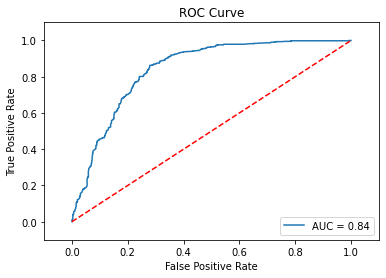

In [13]:
exibirCurvaROC(modeloClassificador, x_test, y_test)

------

### Selecionando as bases para a Validação

In [14]:
# Bases - OC
# top10_bases_modelo_oc_map = {'MG': 'PreProcessamento/balanceadas/OC/ba-oc-7030-mg.xlsx',
#                          'BA': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ba.xlsx',
#                          'PA': 'PreProcessamento/balanceadas/OC/ba-oc-7030-pa.xlsx',
#                          'RO': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ro.xlsx',
#                          'RJ': 'PreProcessamento/balanceadas/OC/ba-oc-7030-rj.xlsx',
#                          'SC': 'PreProcessamento/balanceadas/OC/ba-oc-7030-sc.xlsx',
#                          'CE': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ce.xlsx',
#                          'RS': 'PreProcessamento/balanceadas/OC/ba-oc-7030-rs.xlsx',
#                          'TO': 'PreProcessamento/balanceadas/OC/ba-oc-7030-to.xlsx',
#                          'MT': 'PreProcessamento/balanceadas/OC/ba-oc-7030-mt.xlsx',
#                         }

In [15]:
top10_bases_modelo_oc = ['ba-oc-6040-mg.xlsx', 'ba-oc-6040-ba.xlsx', 'ba-oc-6040-pa.xlsx', 
                         'ba-oc-6040-ro.xlsx', 'ba-oc-6040-rj.xlsx', 'ba-oc-6040-sc.xlsx', 
                         'ba-oc-6040-ce.xlsx', 'ba-oc-6040-rs.xlsx', 'ba-oc-6040-to.xlsx', 
                         'ba-oc-6040-mt.xlsx']

In [16]:
# Bases - IC
# top10_bases_modelo_ic_map = {'BA': 'PreProcessamento/balanceadas/IC/ba-ic-6040-sp.xlsx',
#                         'MG': 'PreProcessamento/balanceadas/IC/ba-ic-6040-mg.xlsx',
#                         'SC': 'PreProcessamento/balanceadas/IC/ba-ic-6040-sc.xlsx',
#                         'RS': 'PreProcessamento/balanceadas/IC/ba-ic-6040-rs.xlsx',
#                         'RJ': 'PreProcessamento/balanceadas/IC/ba-ic-6040-rj.xlsx',
#                         'PB': 'PreProcessamento/balanceadas/IC/ba-ic-6040-pb.xlsx',
#                         'GO': 'PreProcessamento/balanceadas/IC/ba-ic-6040-go.xlsx',
#                         'CE': 'PreProcessamento/balanceadas/IC/ba-ic-6040-ce.xlsx',
#                         'DF': 'PreProcessamento/balanceadas/IC/ba-ic-6040-df.xlsx',
#                         'PA': 'PreProcessamento/balanceadas/IC/ba-ic-6040-pa.xlsx'
#                         }

In [17]:
# Bases - IC
# top10_bases_modelo_ic = ['ba-ic-6040-ba.xlsx', 'ba-ic-6040-mg.xlsx', 'ba-ic-6040-sc.xlsx',
#                         'ba-ic-6040-rs.xlsx', 'ba-ic-6040-rj.xlsx', 'ba-ic-6040-pb.xlsx',
#                         'ba-ic-6040-go.xlsx', 'ba-ic-6040-ce.xlsx', 'ba-ic-6040-df.xlsx',
#                         'ba-ic-6040-pa.xlsx']

In [18]:
# (Modelo OC)
colunasSelecionadasTeste = ['faixaetaria', 'dispneia', 'qntVacinas', 'coriza', 'dorDeGarganta', 
                       'dorDeCabeca', 'obesidade', 'diabetes', 'faixaDiasSintomas']

# (Modelo IC)
# colunasSelecionadasTeste = ['faixaetaria', 'dorDeCabeca', 'dorDeGarganta', 'renal', 'dispneia', 'diabetes',  
#                        'tosse', 'qntVacinas', 'faixaDiasSintomas', 'coriza', 'febre']

### Executando a Validação

In [19]:
alvos = [0, 1]
default_path = 'PreProcessamento/balanceadas/OC/'
listaBases = top10_bases_modelo_oc
alvo = 'evolucaoCaso'

desempenhoDosModelos = pd.DataFrame()
for indice in range(0, len(listaBases)):
    covidData = pd.read_excel(default_path + listaBases[indice])
#     covidData['evolucaoCaso'] = covidData['evolucaoCaso'].replace([1, 2], [1, 0])
#     print(covidData['evolucaoCaso'].value_counts())
    
    dadosTeste = covidData.loc[:, colunasSelecionadasTeste]
    dadosAlvo =  covidData.loc[:, alvo]
     
    metricasMap = mf.calcularMetricasValidacao(dadosTeste, dadosAlvo, listaBases[indice], modeloClassificador, alvos)
    desempenhoDosModelos = pd.concat([desempenhoDosModelos, pd.DataFrame([metricasMap])]) 

In [20]:
desempenhoDosModelos

,Acurácia,AUC,Base,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1)
0,81.67,0.88,ba-oc-6040-mg.xlsx,75.70,79.75,77.68,86.01,82.95,84.45
0,85.28,0.92,ba-oc-6040-ba.xlsx,78.52,87.01,82.54,90.66,84.13,87.28
0,84.43,0.92,ba-oc-6040-pa.xlsx,76.69,87.81,81.87,90.99,82.18,86.36
0,83.90,0.92,ba-oc-6040-ro.xlsx,78.58,82.16,80.33,87.73,85.06,86.38
0,80.41,0.88,ba-oc-6040-rj.xlsx,72.61,81.95,77.00,86.84,79.39,82.95
0,81.86,0.87,ba-oc-6040-sc.xlsx,76.47,78.99,77.71,85.66,83.78,84.71
0,84.49,0.91,ba-oc-6040-ce.xlsx,78.35,84.51,81.31,89.13,84.47,86.74
0,76.42,0.79,ba-oc-6040-rs.xlsx,77.44,57.99,66.32,75.98,88.72,81.86
0,84.28,0.91,ba-oc-6040-to.xlsx,75.48,89.71,81.98,92.21,80.68,86.06
0,85.22,0.89,ba-oc-6040-mt.xlsx,81.54,81.54,81.54,87.67,87.67,87.67


### Calculando a média das Métricas

In [21]:
# Identificando a média 
media = desempenhoDosModelos.mean()

# Inserindo as outras colunas
# media['Modelo'] = "-"
media['Base'] = 'Média dos Modelos'

/tmp/ipykernel_13789/1463340102.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  media = desempenhoDosModelos.mean()


In [22]:
# Adicionando a média dos valores
desempenhoDosModelos = desempenhoDosModelos.append(media, ignore_index=True)
desempenhoDosModelos

,Acurácia,AUC,Base,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1)
0,81.670,0.880,ba-oc-6040-mg.xlsx,75.700,79.750,77.680,86.010,82.950,84.450
1,85.280,0.920,ba-oc-6040-ba.xlsx,78.520,87.010,82.540,90.660,84.130,87.280
2,84.430,0.920,ba-oc-6040-pa.xlsx,76.690,87.810,81.870,90.990,82.180,86.360
3,83.900,0.920,ba-oc-6040-ro.xlsx,78.580,82.160,80.330,87.730,85.060,86.380
4,80.410,0.880,ba-oc-6040-rj.xlsx,72.610,81.950,77.000,86.840,79.390,82.950
5,81.860,0.870,ba-oc-6040-sc.xlsx,76.470,78.990,77.710,85.660,83.780,84.710
6,84.490,0.910,ba-oc-6040-ce.xlsx,78.350,84.510,81.310,89.130,84.470,86.740
7,76.420,0.790,ba-oc-6040-rs.xlsx,77.440,57.990,66.320,75.980,88.720,81.860
8,84.280,0.910,ba-oc-6040-to.xlsx,75.480,89.710,81.980,92.210,80.680,86.060
9,85.220,0.890,ba-oc-6040-mt.xlsx,81.540,81.540,81.540,87.670,87.670,87.670


In [23]:
# Convertendo series para dict
# media_dict = pd.Series(media.values, index=media.keys).to_dict()

### Salvando o Desempenho

In [25]:
mf.salvarBaseDeDados(desempenhoDosModelos, 'validacao-modelo-reduzido-oc.xlsx')